In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
config = {
    'BATCH_SIZE':32,
    'IMAGE_SIZE': (224, 224),
    'SEED':42,
    'LEARNING_RATE':0.003,
    'EPOCHS':15
}

In [7]:
data_dir = '/content/drive/MyDrive/Doing_lab/food-data'

train_image_gen = ImageDataGenerator(validation_split=0.2)                            
validation_image_gen = ImageDataGenerator(validation_split=0.2)

train_generator = train_image_gen.flow_from_directory(
    data_dir,
    shuffle=True,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='training')

validation_generator = validation_image_gen.flow_from_directory(
    data_dir, 
    shuffle=False,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='validation')

Found 4000 images belonging to 50 classes.
Found 1000 images belonging to 50 classes.


In [8]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49}
{'apple_pie': 0, 'baby_back_ribs': 1

In [9]:
from tensorflow.keras.applications import EfficientNetB0

# 클래스 개수
num_classes = train_generator.num_classes

# 모델 생성 함수
# 사전학습 모델을 불러와 마지막 레이어를 제외하고 전부 frozen

def create_model(input_shape, num_classes):
  base_model = EfficientNetB0(include_top=False, weights='imagenet')
  base_model.trainable = False
  
  inputs = Input(shape=input_shape)
  x = base_model(inputs, training=False)

  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)
  opt = Adam(learning_rate=config['LEARNING_RATE'])

  model.compile(
      optimizer=opt,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

model = create_model(config['IMAGE_SIZE'] + (3,), num_classes)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                64050     
Total params: 4,113,621
Trainable params: 64,050
Non-trainable params: 4,049,571
_________________________________________________________________


In [10]:
checkpoint_path = '/content/drive/MyDrive/Doing_lab/checkpoint/CASE1_EfficientNetB0.h5'

mc = ModelCheckpoint(filepath=checkpoint_path,
                     save_weight_only=True,
                     save_best_only=True,
                     monitor='val_loss',
                     verbose=1)

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1)

hist = model.fit(train_generator,
                 validation_data=validation_generator,
                 epochs=config['EPOCHS'],
                 callbacks=[mc, es])

Epoch 1/15
125/125 [==============================] - 3070s 24s/step - loss: 2.6985 - accuracy: 0.3403 - val_loss: 1.4605 - val_accuracy: 0.5970

Epoch 00001: val_loss improved from inf to 1.46048, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE1_EfficientNetB0.h5
Epoch 2/15
125/125 [==============================] - 37s 292ms/step - loss: 1.0108 - accuracy: 0.7424 - val_loss: 1.3282 - val_accuracy: 0.6270

Epoch 00002: val_loss improved from 1.46048 to 1.32816, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE1_EfficientNetB0.h5
Epoch 3/15
125/125 [==============================] - 36s 291ms/step - loss: 0.6701 - accuracy: 0.8432 - val_loss: 1.2988 - val_accuracy: 0.6360

Epoch 00003: val_loss improved from 1.32816 to 1.29877, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE1_EfficientNetB0.h5
Epoch 4/15
125/125 [==============================] - 36s 291ms/step - loss: 0.4937 - accuracy: 0.8938 - val_loss: 1.2892 - val_accuracy: 0.6490



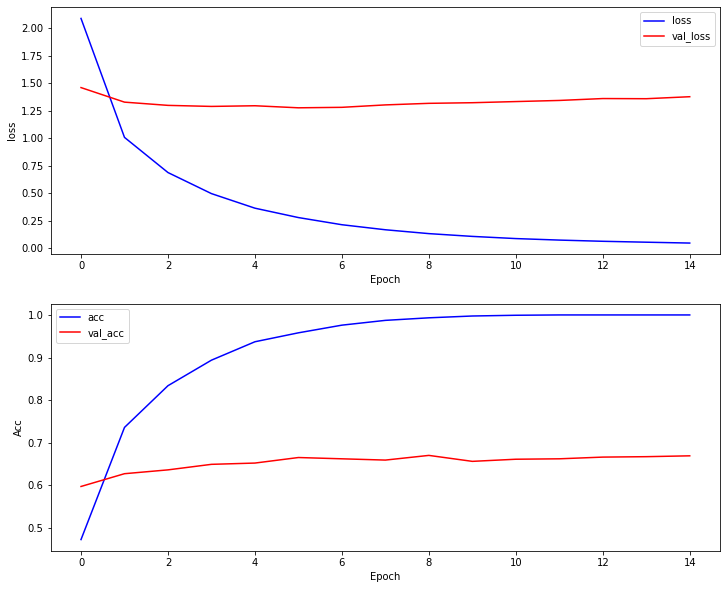

In [11]:
# 그래프
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# loss, val_loss
ax[0].set_ylabel("loss")
ax[0].set_xlabel("Epoch")
ax[0].plot(hist.history['loss'], 'b-', label = 'loss')
ax[0].plot(hist.history['val_loss'], 'r-', label = 'val_loss')
ax[0].legend()

# acc, val_acc
ax[1].set_ylabel("Acc")
ax[1].set_xlabel("Epoch")
ax[1].plot(hist.history['accuracy'], 'b-', label = 'acc')
ax[1].plot(hist.history['val_accuracy'], 'r-', label = 'val_acc')
ax[1].legend()

plt.show()

In [12]:
data_dir = '/content/drive/MyDrive/Doing_lab/food-data'

# apply augmentation 
train_image_gen = ImageDataGenerator(validation_split=0.2,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                            
validation_image_gen = ImageDataGenerator(validation_split=0.2)

train_generator = train_image_gen.flow_from_directory(
    data_dir,
    shuffle=True,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='training')

validation_generator = validation_image_gen.flow_from_directory(
    data_dir, 
    shuffle=False,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='validation')

Found 4000 images belonging to 50 classes.
Found 1000 images belonging to 50 classes.


In [13]:
from tensorflow.keras.applications import EfficientNetB0

# 클래스 개수
num_classes = train_generator.num_classes

# 모델 생성 함수
# 사전학습 모델을 불러와 마지막 레이어를 제외하고 전부 frozen

def create_model(input_shape, num_classes):
  base_model = EfficientNetB0(include_top=False, weights='imagenet')
  base_model.trainable = False
  
  inputs = Input(shape=input_shape)
  x = base_model(inputs, training=False)

  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)
  opt = Adam(learning_rate=config['LEARNING_RATE'])

  model.compile(
      optimizer=opt,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

model = create_model(config['IMAGE_SIZE'] + (3,), num_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                64050     
Total params: 4,113,621
Trainable params: 64,050
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
checkpoint_path = '/content/drive/MyDrive/Doing_lab/checkpoint/CASE2_EfficientNetB0.h5'

mc = ModelCheckpoint(filepath=checkpoint_path,
                     save_weight_only=True,
                     save_best_only=True,
                     monitor='val_loss',
                     verbose=1)

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1)

hist = model.fit(train_generator,
                 validation_data=validation_generator,
                 epochs=config['EPOCHS'],
                 callbacks=[mc, es])

Epoch 1/15
125/125 [==============================] - 88s 653ms/step - loss: 3.0278 - accuracy: 0.2588 - val_loss: 1.5543 - val_accuracy: 0.5860

Epoch 00001: val_loss improved from inf to 1.55427, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE2_EfficientNetB0.h5
Epoch 2/15
125/125 [==============================] - 80s 641ms/step - loss: 1.4824 - accuracy: 0.6036 - val_loss: 1.4167 - val_accuracy: 0.5970

Epoch 00002: val_loss improved from 1.55427 to 1.41673, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE2_EfficientNetB0.h5
Epoch 3/15
125/125 [==============================] - 80s 639ms/step - loss: 1.2227 - accuracy: 0.6692 - val_loss: 1.3584 - val_accuracy: 0.6170

Epoch 00003: val_loss improved from 1.41673 to 1.35842, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE2_EfficientNetB0.h5
Epoch 4/15
125/125 [==============================] - 80s 639ms/step - loss: 1.0401 - accuracy: 0.7188 - val_loss: 1.3808 - val_accuracy: 0.6250



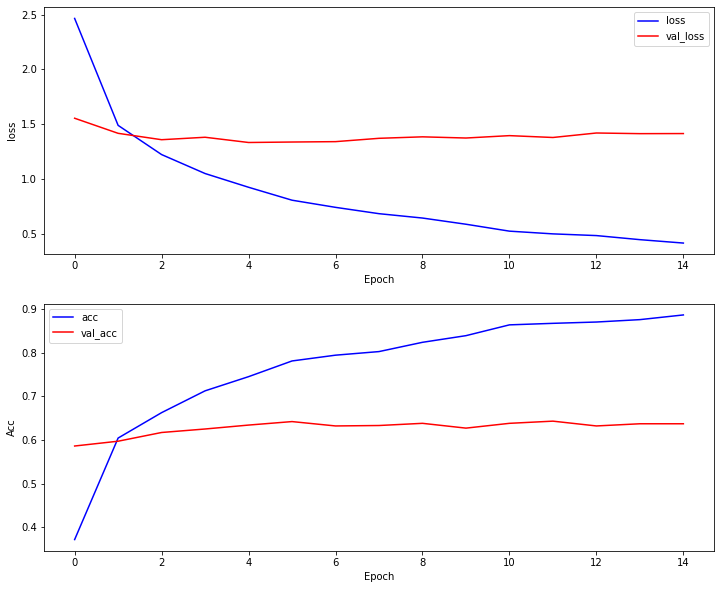

In [15]:
# 그래프
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# loss, val_loss
ax[0].set_ylabel("loss")
ax[0].set_xlabel("Epoch")
ax[0].plot(hist.history['loss'], 'b-', label = 'loss')
ax[0].plot(hist.history['val_loss'], 'r-', label = 'val_loss')
ax[0].legend()

# acc, val_acc
ax[1].set_ylabel("Acc")
ax[1].set_xlabel("Epoch")
ax[1].plot(hist.history['accuracy'], 'b-', label = 'acc')
ax[1].plot(hist.history['val_accuracy'], 'r-', label = 'val_acc')
ax[1].legend()

plt.show()

In [74]:
new_dict = dict([(value, key) for key, value in  train_generator.class_indices.items()])

In [59]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

validation_generator.reset()

# 예측값 
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=-1)

# 실제값
class_names = [key for key, value in train_generator.class_indices.items()]
y_real = validation_generator.classes[validation_generator.index_array]

# # confusion matrix
cm = confusion_matrix(y_real, y_pred)

# accuracy_score, recall_score, precision_score, f1_score
print(classification_report(y_real, y_pred, target_names=class_names))

print("Acc :", accuracy_score(y_real, y_pred))
print("Recall :", recall_score(y_real, y_pred, average='macro'))
print("Precision :", precision_score(y_real, y_pred, average='macro'))

                         precision    recall  f1-score   support

              apple_pie       0.40      0.30      0.34        20
         baby_back_ribs       0.82      0.70      0.76        20
                baklava       0.45      0.50      0.48        20
         beef_carpaccio       0.56      0.50      0.53        20
           beef_tartare       0.64      0.35      0.45        20
             beet_salad       0.54      0.35      0.42        20
               beignets       1.00      0.60      0.75        20
               bibimbap       1.00      0.90      0.95        20
          bread_pudding       0.27      0.35      0.30        20
      breakfast_burrito       0.49      0.85      0.62        20
             bruschetta       0.39      0.55      0.46        20
           caesar_salad       0.79      0.75      0.77        20
                cannoli       0.62      0.65      0.63        20
          caprese_salad       0.57      0.80      0.67        20
            carrot_cake 

In [34]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 6  0  1 ...  1  0  0]
 [ 0 14  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  1 ...  0  0  2]]


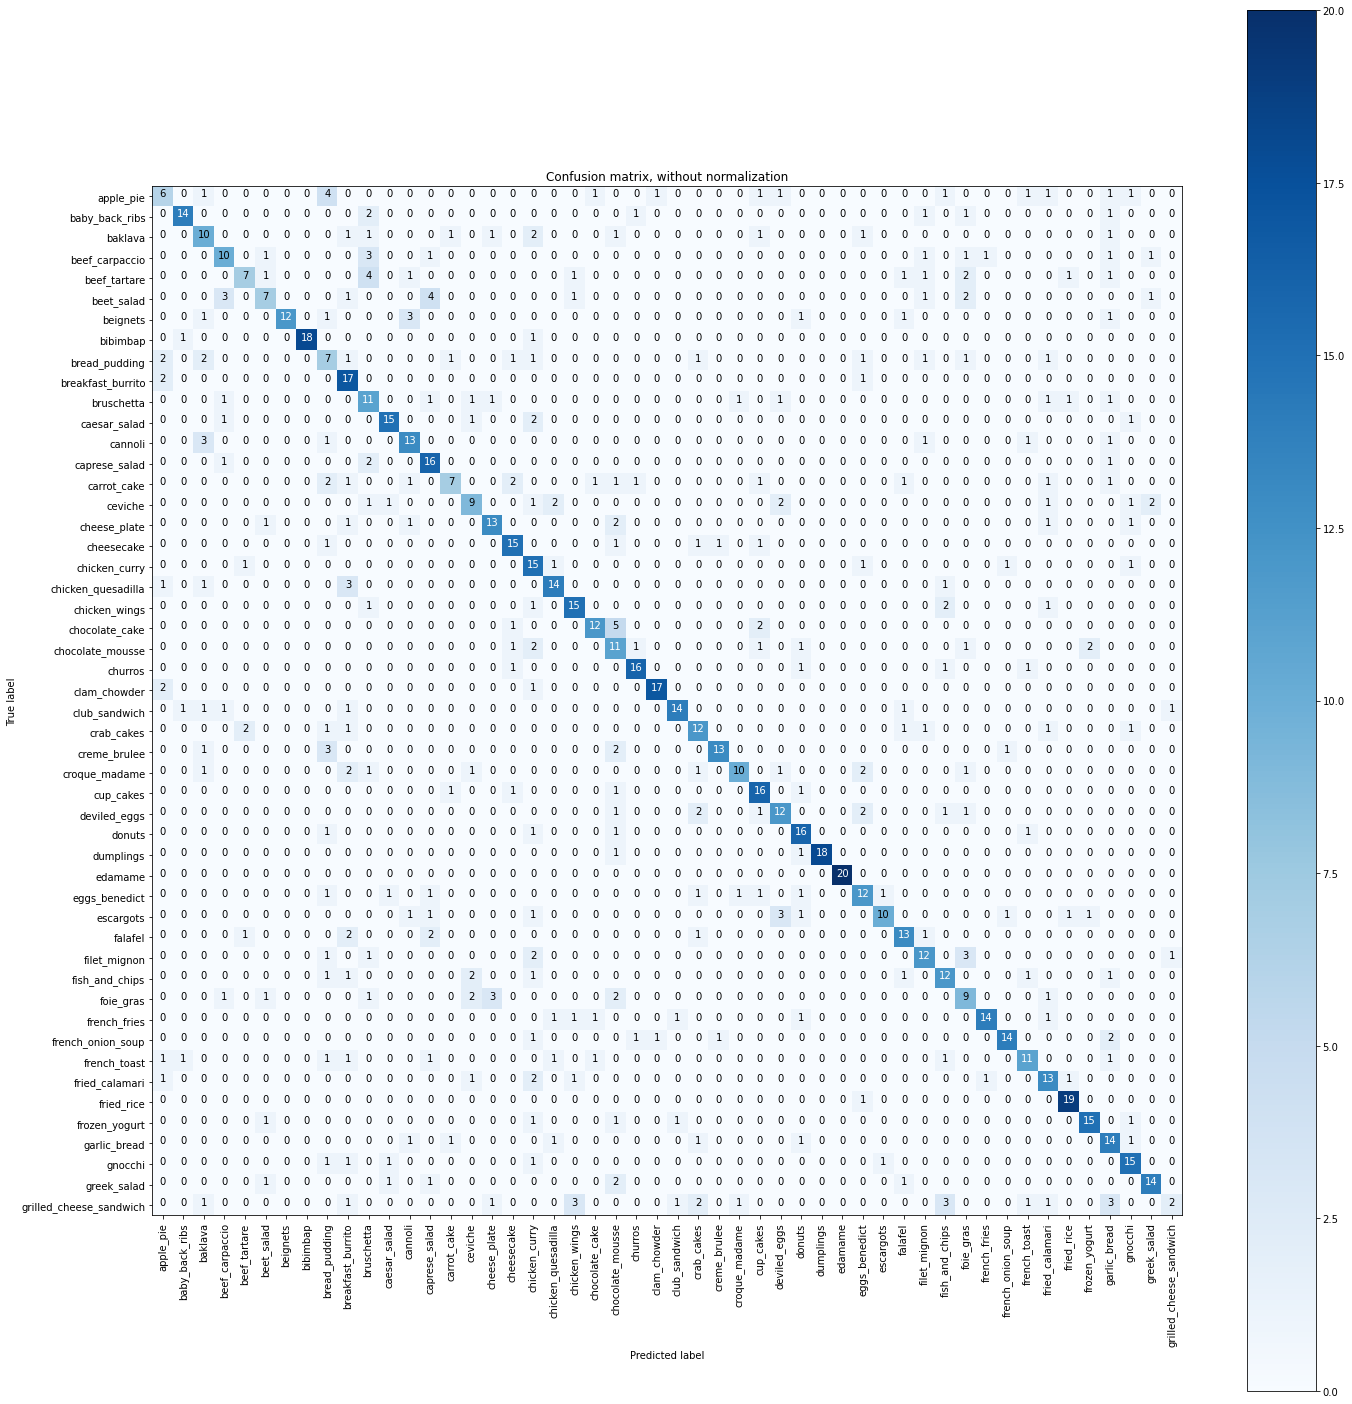

In [60]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')